In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [3]:
#Read dataset
df = pd.read_csv('./data/CICIDS2017_sample.csv') 
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,4,2,0,37,0,31,6,18.500000,17.677670,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,142377,46,62,1325,105855,570,0,28.804348,111.407285,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,118873,23,28,1169,45025,570,0,50.826087,156.137367,2896,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,143577,43,55,1301,107289,570,0,30.255814,115.178969,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,143745,49,59,1331,110185,570,0,27.163265,108.067176,4344,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56656,234,2,2,64,232,32,32,32.000000,0.000000,116,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56657,133288,2,2,94,482,47,47,47.000000,0.000000,241,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
56658,11507694,5,4,450,3525,450,0,90.000000,201.246118,3525,...,32,893.0,0.0,893,893,6503640.0,0.0,6503640,6503640,DoS
56659,11507707,8,6,416,11632,416,0,52.000000,147.078211,5792,...,32,897.0,0.0,897,897,6503122.0,0.0,6503122,6503122,DoS


In [4]:
df.Label.value_counts()

Label
BENIGN          22731
DoS             19035
PortScan         7946
BruteForce       2767
WebAttack        2180
Bot              1966
Infiltration       36
Name: count, dtype: int64

### Preprocessing (normalization and padding values)


In [5]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [6]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])

In [7]:
df.Label.value_counts()

Label
0    22731
3    19035
5     7946
2     2767
6     2180
1     1966
4       36
Name: count, dtype: int64

In [8]:
X = df.drop(['Label'], axis=1).values
y = df['Label'].values

# Flatten y to ensure it is a 1-dimensional array
y = np.ravel(y)

# Check the shapes to confirm
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")


Shape of X: (56661, 77)
Shape of y: (56661,)


In [9]:
if not np.issubdtype(y.dtype, np.integer):
    y = y.astype(int)

unique_values = np.unique(y)
print("Unique values in y after conversion:", unique_values)


Unique values in y after conversion: [0 1 2 3 4 5 6]


In [10]:
from imblearn.over_sampling import SMOTE

# Define SMOTE with the correct sampling strategy
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample
X, y = smote.fit_resample(X, y)

In [11]:
pd.Series(y).value_counts()

0    22731
3    22731
5    22731
1    22731
4    22731
6    22731
2    22731
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [14]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Reshape the data for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Verify shapes after reshaping
print("Shape of X_train_cnn:", X_train_cnn.shape)
print("Shape of X_test_cnn:", X_test_cnn.shape)

Shape of X_train: (127293, 77)
Shape of y_train: (127293, 7)
Shape of X_test: (31824, 77)
Shape of y_test: (31824, 7)
Shape of X_train_cnn: (127293, 77, 1)
Shape of X_test_cnn: (31824, 77, 1)


Epoch 1/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9193 - loss: 0.2711 - val_accuracy: 0.9624 - val_loss: 0.1242
Epoch 2/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9631 - loss: 0.1190 - val_accuracy: 0.9518 - val_loss: 0.1323
Epoch 3/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.9681 - loss: 0.1022 - val_accuracy: 0.9716 - val_loss: 0.1208
Epoch 4/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9722 - loss: 0.0906 - val_accuracy: 0.9765 - val_loss: 0.1434
Epoch 5/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9760 - loss: 0.0806 - val_accuracy: 0.9753 - val_loss: 0.1864
Epoch 6/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9777 - loss: 0.0741 - val_accuracy: 0.9739 - val_loss: 0.2240
Epoch 7/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9782 - loss: 0.0721 - val_accuracy: 0.9788 - val_loss: 0.2076
Epoch 8/20
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.9793 - loss: 0

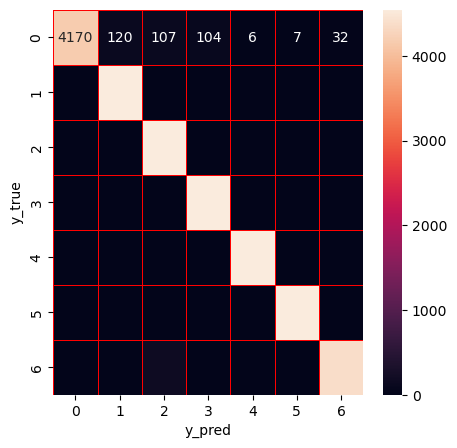

In [15]:
# Reshape the data for CNN input (assuming your data is not in image format)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Create and compile CNN model
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
model_cnn.fit(X_train_cnn, y_train, epochs=20, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn = model_cnn.predict(X_test_cnn)

# Convert predictions and true values to original labels
y_test_decoded = np.argmax(y_test, axis=1)
y_predict_cnn_decoded = np.argmax(y_predict_cnn, axis=1)

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_decoded, y_predict_cnn_decoded, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test_decoded, y_predict_cnn_decoded))

# Confusion matrix
cm_cnn = confusion_matrix(y_test_decoded, y_predict_cnn_decoded)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


Reloading Tuner from my_dir\cnn_tuning\tuner0.json
Epoch 1/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.8895 - loss: 0.3847 - val_accuracy: 0.9401 - val_loss: 0.1538
Epoch 2/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9584 - loss: 0.1364 - val_accuracy: 0.9651 - val_loss: 0.1172
Epoch 3/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9653 - loss: 0.1171 - val_accuracy: 0.9632 - val_loss: 0.1158
Epoch 4/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9674 - loss: 0.1054 - val_accuracy: 0.9697 - val_loss: 0.0976
Epoch 5/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9688 - loss: 0.1001 - val_accuracy: 0.9706 - val_loss: 0.0920
Epoch 6/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.9710 - loss: 0.0943 - val_accuracy: 0.9715 - val_loss: 0.0859
Epoch 7/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9727 - loss: 0.0895 - val_accuracy: 0.9724 - val_loss: 0.0835
Epoch 8/10
3978/3978 ━━━━━━━━━━━

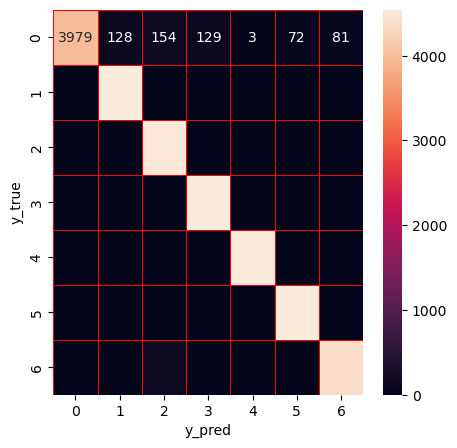

In [16]:
import keras_tuner as kt

# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv1D(
        filters=hp.Int('filters', min_value=32, max_value=128, step=32),
        kernel_size=hp.Int('kernel_size', min_value=3, max_value=5, step=1),
        activation='relu',
        input_shape=(X_train_cnn.shape[1], 1)
    ))
    model.add(tf.keras.layers.MaxPooling1D(pool_size=hp.Int('pool_size', min_value=2, max_value=4, step=1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(
        units=hp.Int('units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10, 
    executions_per_trial=1,
    directory='my_dir',
    project_name='cnn_tuning'
)

# Run the hyperparameter search
tuner.search(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model_cnn = tuner.hypermodel.build(best_hps)

# Train the model with the optimal hyperparameters
history = model_cnn.fit(X_train_cnn, y_train, epochs=10, validation_data=(X_test_cnn, y_test))

# Evaluate CNN model
cnn_score = model_cnn.evaluate(X_test_cnn, y_test, verbose=0)
print('Accuracy of CNN: ' + str(cnn_score[1]))

# Predict using the model
y_predict_cnn = model_cnn.predict(X_test_cnn)

# Convert predictions and true values to original labels
y_test_decoded = np.argmax(y_test, axis=1)
y_predict_cnn_decoded = np.argmax(y_predict_cnn, axis=1)

# Calculate precision, recall, and F1-score
precision_cnn, recall_cnn, fscore_cnn, _ = precision_recall_fscore_support(y_test_decoded, y_predict_cnn_decoded, average='weighted')
print('Precision of CNN: ' + str(precision_cnn))
print('Recall of CNN: ' + str(recall_cnn))
print('F1-score of CNN: ' + str(fscore_cnn))

# Print classification report
print(classification_report(y_test_decoded, y_predict_cnn_decoded))

# Confusion matrix
cm_cnn = confusion_matrix(y_test_decoded, y_predict_cnn_decoded)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### LSTM

Shape of X_train: (127293, 77)
Shape of y_train: (127293, 7)
Shape of X_test: (31824, 77)
Shape of y_test: (31824, 7)
Shape of X_train_lstm: (127293, 1, 77)
Shape of X_test_lstm: (31824, 1, 77)
Epoch 1/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9062 - loss: 0.3215 - val_accuracy: 0.9638 - val_loss: 0.1126
Epoch 2/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9653 - loss: 0.1070 - val_accuracy: 0.9681 - val_loss: 0.0943
Epoch 3/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9696 - loss: 0.0912 - val_accuracy: 0.9739 - val_loss: 0.0773
Epoch 4/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9735 - loss: 0.0822 - val_accuracy: 0.9748 - val_loss: 0.0789
Epoch 5/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9761 - loss: 0.0757 - val_accuracy: 0.9783 - val_loss: 0.0745
Epoch 6/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - accuracy: 0.9779 - loss: 0.0707 - val_accuracy: 0.9784 - val_loss: 0.0796
Epoch 7/10
3978/3978 ━━━━━

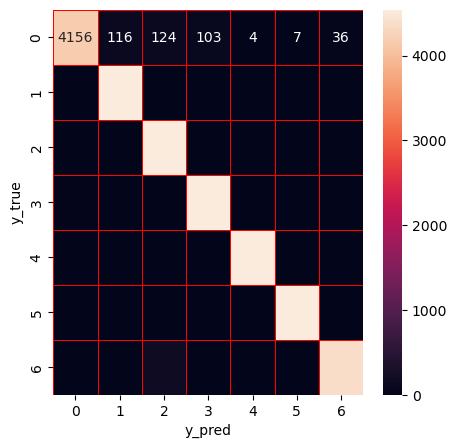

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

# One-hot encode labels
onehot_encoder = OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = onehot_encoder.transform(y_test.reshape(-1, 1))

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

# Reshape the data for LSTM input (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Verify shapes after reshaping
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)

# Create and compile LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train LSTM model
history = model_lstm.fit(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))

# Evaluate LSTM model
lstm_score = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print('Accuracy of LSTM: ' + str(lstm_score[1]))

# Predict using the model
y_predict_lstm = model_lstm.predict(X_test_lstm)

# Convert predictions and true values to original labels
y_test_decoded = np.argmax(y_test, axis=1)
y_predict_lstm_decoded = np.argmax(y_predict_lstm, axis=1)

# Calculate precision, recall, and F1-score
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test_decoded, y_predict_lstm_decoded, average='weighted')
print('Precision of LSTM: ' + str(precision_lstm))
print('Recall of LSTM: ' + str(recall_lstm))
print('F1-score of LSTM: ' + str(fscore_lstm))

# Print classification report
print(classification_report(y_test_decoded, y_predict_lstm_decoded))

# Confusion matrix
cm_lstm = confusion_matrix(y_test_decoded, y_predict_lstm_decoded)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Shape of X_train_lstm: (127293, 1, 77)
Shape of X_test_lstm: (31824, 1, 77)
Reloading Tuner from my_dir\lstm_tuning\tuner0.json
Epoch 1/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.9254 - loss: 0.2603 - val_accuracy: 0.9658 - val_loss: 0.1169
Epoch 2/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9659 - loss: 0.1057 - val_accuracy: 0.9700 - val_loss: 0.0943
Epoch 3/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9717 - loss: 0.0883 - val_accuracy: 0.9738 - val_loss: 0.0816
Epoch 4/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9762 - loss: 0.0768 - val_accuracy: 0.9779 - val_loss: 0.0819
Epoch 5/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9777 - loss: 0.0723 - val_accuracy: 0.9802 - val_loss: 0.0757
Epoch 6/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9788 - loss: 0.0683 - val_accuracy: 0.9730 - val_loss: 0.0781
Epoch 7/10
3978/3978 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9792 - loss: 0.07

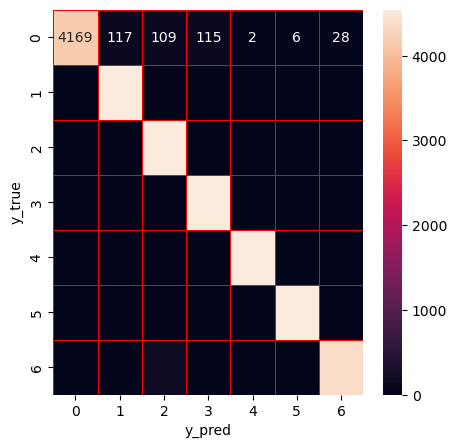

In [19]:
# Reshape the data for LSTM input (samples, timesteps, features)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Verify shapes after reshaping
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)

# Define the model building function for Keras Tuner
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])
    ))
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=256, step=32),
        activation='relu'
    ))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # You can adjust this based on your needs
    executions_per_trial=1,
    directory='my_dir',
    project_name='lstm_tuning'
)

# Run the hyperparameter search
tuner.search(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model_lstm = tuner.hypermodel.build(best_hps)

# Train the model with the optimal hyperparameters
history = model_lstm.fit(X_train_lstm, y_train, epochs=10, validation_data=(X_test_lstm, y_test))

# Evaluate LSTM model
lstm_score = model_lstm.evaluate(X_test_lstm, y_test, verbose=0)
print('Accuracy of LSTM: ' + str(lstm_score[1]))

# Predict using the model
y_predict_lstm = model_lstm.predict(X_test_lstm)

# Convert predictions and true values to original labels
y_test_decoded = np.argmax(y_test, axis=1)
y_predict_lstm_decoded = np.argmax(y_predict_lstm, axis=1)

# Calculate precision, recall, and F1-score
precision_lstm, recall_lstm, fscore_lstm, _ = precision_recall_fscore_support(y_test_decoded, y_predict_lstm_decoded, average='weighted')
print('Precision of LSTM: ' + str(precision_lstm))
print('Recall of LSTM: ' + str(recall_lstm))
print('F1-score of LSTM: ' + str(fscore_lstm))

# Print classification report
print(classification_report(y_test_decoded, y_predict_lstm_decoded))

# Confusion matrix
cm_lstm = confusion_matrix(y_test_decoded, y_predict_lstm_decoded)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm_lstm, annot=True, linewidths=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Anomaly-based IDS
